# 

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Step 1 - Set Up the Simulation

Start by setting up the colors for the dice, the number of simulations we want to run, and the number of dice to roll per simulation.

### Why Ten Dice per Roll?

I've chosen to roll ten dice per simulation of a roll, because the game includes ten dice and the rules suggest that you roll in batches of ten. Because BLACK and WHITE results are wild, this fact can impact how many "hits" are actually allocatable vs ignored.

In [54]:
NUM_SIMULATIONS = 10000
COLORS = ("YELLOW", "BLUE", "GREEN", "RED", "BLACK", "WHITE")
COLOR_LOOKUP = {
    "YELLOW": "#BBBB77",
    "BLUE": "#77AABB",
    "GREEN": "#77BB77",
    "RED": "#BB7777",
    "BLACK": "#222222",
    "WHITE": "#B0B0B0"
}
DIE_FACES = [
    "YELLOW",
    "YELLOW",
    "YELLOW",
    "YELLOW",
    "BLUE",
    "BLUE",
    "BLUE",
    "GREEN",
    "GREEN",
    "RED",
    "BLACK",
    "WHITE"
]
NUM_DICE = 10

## Step 2 - Generate Rolls for Each Simulation

This is very straightforward in Python. We'll use numpy's `random.choice` function to simulate rolling ten die at once. All results are collected into a list of lists and then turned into a DataFrame so we can more easily manipulate and analyze the data.

In [55]:
random_choices = []
for _ in range(NUM_SIMULATIONS):
    choices = np.random.choice(DIE_FACES, size=NUM_DICE)
    random_choices.append(choices)

df_random_choices = pd.DataFrame(random_choices)
df_random_choices


,0,1,2,3,4,5,6,7,8,9
0,BLUE,YELLOW,YELLOW,RED,GREEN,YELLOW,YELLOW,BLUE,BLUE,GREEN
1,BLUE,BLUE,WHITE,GREEN,BLUE,GREEN,YELLOW,BLACK,BLUE,WHITE
2,YELLOW,BLACK,YELLOW,YELLOW,BLUE,GREEN,BLUE,GREEN,YELLOW,YELLOW
3,BLUE,BLUE,YELLOW,BLUE,RED,BLACK,BLUE,GREEN,BLUE,YELLOW
4,YELLOW,RED,GREEN,YELLOW,BLUE,YELLOW,WHITE,GREEN,YELLOW,WHITE
...,...,...,...,...,...,...,...,...,...,...
9995,BLACK,BLACK,RED,WHITE,BLUE,YELLOW,YELLOW,YELLOW,YELLOW,GREEN
9996,WHITE,YELLOW,WHITE,GREEN,RED,YELLOW,YELLOW,GREEN,WHITE,YELLOW
9997,GREEN,YELLOW,YELLOW,YELLOW,YELLOW,WHITE,YELLOW,BLUE,GREEN,YELLOW
9998,BLUE,BLACK,RED,BLACK,YELLOW,BLACK,RED,BLACK,YELLOW,GREEN


## Step 3 - Analyze the Results

The proportions of colors on the dice are known, so the expected value for a given roll or set of rules is easy to compute and doesn't require a simulation.

But what is less clear is the *variability* you might expect from each color, and also the aggregate impact of the wild BLACK and WHITE results. So here we look at the distribution by each color.

### Get and Graph a Distribution for a Color

Here I'm just testing the steps required to aggregate the results of the simulations and plot the distribution of a single color.

In [56]:
yellow_distribution = df_random_choices.apply(lambda row: row.value_counts().get('YELLOW', 0), axis=1)
yellow_distribution

0       4
1       1
2       5
3       2
4       4
       ..
9995    4
9996    4
9997    6
9998    2
9999    4
Length: 10000, dtype: int64

(array([1.850e+02, 8.600e+02, 1.911e+03, 2.601e+03, 2.285e+03, 1.378e+03,
        5.790e+02, 1.620e+02, 3.700e+01, 2.000e+00]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

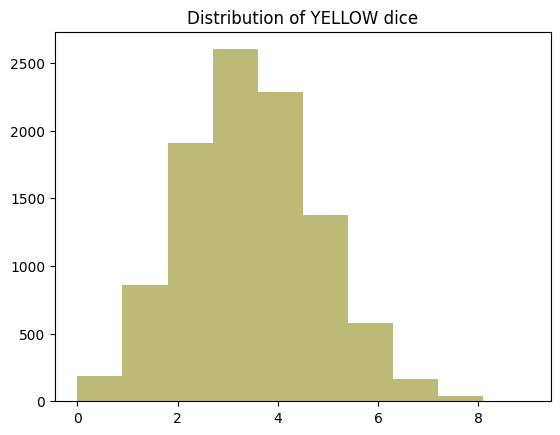

In [57]:
plt.clf()
plt.title("Distribution of YELLOW dice")
plt.hist(yellow_distribution, bins=df_random_choices.shape[1], color=COLOR_LOOKUP["YELLOW"])

### Aggregate and Plot All Colors

With that figured out for yellow, we can put all colors on the same plot to see how they compare.

<Figure size 640x480 with 0 Axes>

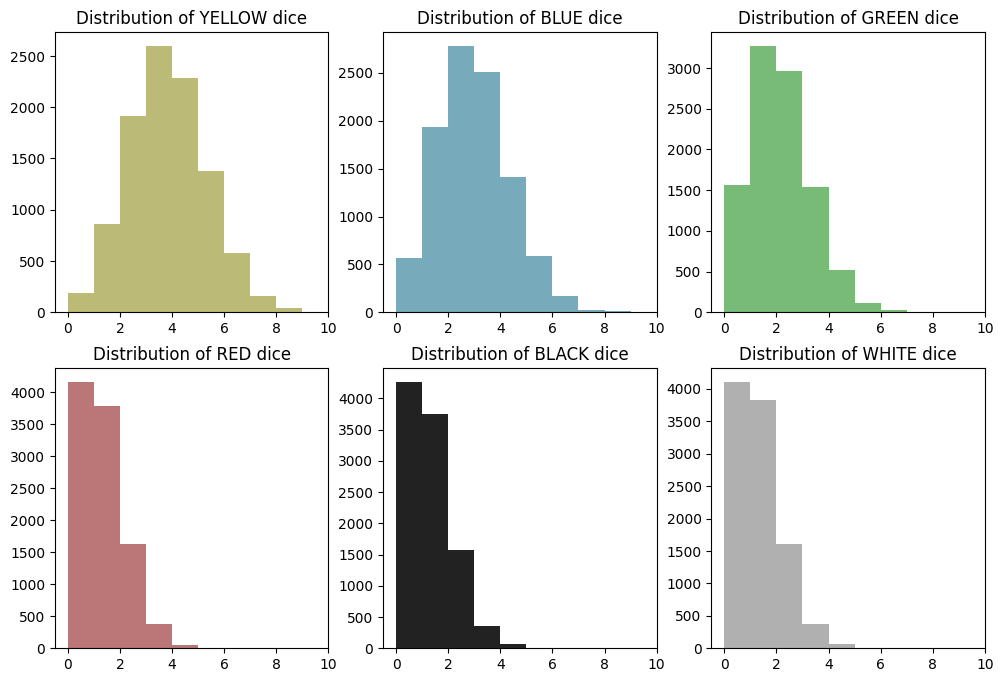

In [58]:
plt.clf()

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, color in enumerate(COLORS):
    distribution = df_random_choices.apply(lambda row: row.value_counts().get(color, 0), axis=1)
    axes[i].hist(distribution, bins=range(df_random_choices.shape[1] + 1), color=COLOR_LOOKUP[color])
    axes[i].set_title(f"Distribution of {color} dice")
    axes[i].set_xlim(right=df_random_choices.shape[1])  # Set max value on x-axis

plt.show()


### What We See

Distributions appear normally distributed around the expected value for their color. There's a slight skew, because the distributions are discrete and values can't go negative, but the shape is generally normal.

### Adding in White and Black Results

This step is a bit tricky, and the results may not be entirely correct, depending on what you're looking to get out of the problem. My approach here is to add the wild results to all colors. Then we look at the 'before wilds' and 'after wilds' distributions for each color to see how BLACK and WHITE rolls impact the distribution of hits.

In practice you can only apply a wild to one color, not all of them. So doing it this way overstates the total number of hits across all colors. So you should look at the 'after wilds' distributions as a sort of upper bound on the number of hits you might expect.

In [59]:
df_by_color = df_random_choices.apply(lambda row: pd.Series(row.value_counts()).fillna(0), axis=1)
df_by_color.fillna(0, inplace=True)
df_by_color

,BLACK,BLUE,GREEN,RED,WHITE,YELLOW
0,0.0,3.0,2.0,1.0,0.0,4.0
1,1.0,4.0,2.0,0.0,2.0,1.0
2,1.0,2.0,2.0,0.0,0.0,5.0
3,1.0,5.0,1.0,1.0,0.0,2.0
4,0.0,1.0,2.0,1.0,2.0,4.0
...,...,...,...,...,...,...
9995,2.0,1.0,1.0,1.0,1.0,4.0
9996,0.0,0.0,2.0,1.0,3.0,4.0
9997,0.0,1.0,2.0,0.0,1.0,6.0
9998,4.0,1.0,1.0,2.0,0.0,2.0


In [60]:
df_black = df_by_color.pop("BLACK")
df_white = df_by_color.pop("WHITE")
df_by_color

,BLUE,GREEN,RED,YELLOW
0,3.0,2.0,1.0,4.0
1,4.0,2.0,0.0,1.0
2,2.0,2.0,0.0,5.0
3,5.0,1.0,1.0,2.0
4,1.0,2.0,1.0,4.0
...,...,...,...,...
9995,1.0,1.0,1.0,4.0
9996,0.0,2.0,1.0,4.0
9997,1.0,2.0,0.0,6.0
9998,1.0,1.0,2.0,2.0


In [61]:
df_black

0       0.0
1       1.0
2       1.0
3       1.0
4       0.0
       ... 
9995    2.0
9996    0.0
9997    0.0
9998    4.0
9999    1.0
Name: BLACK, Length: 10000, dtype: float64

In [62]:
df_white

0       0.0
1       2.0
2       0.0
3       0.0
4       2.0
       ... 
9995    1.0
9996    3.0
9997    1.0
9998    0.0
9999    1.0
Name: WHITE, Length: 10000, dtype: float64

Next, add the BLACK results to each color. This can be done with simple matrix addition.

In [63]:
df_by_color = df_by_color.add(df_black, axis=0)
df_by_color


,BLUE,GREEN,RED,YELLOW
0,3.0,2.0,1.0,4.0
1,5.0,3.0,1.0,2.0
2,3.0,3.0,1.0,6.0
3,6.0,2.0,2.0,3.0
4,1.0,2.0,1.0,4.0
...,...,...,...,...
9995,3.0,3.0,3.0,6.0
9996,0.0,2.0,1.0,4.0
9997,1.0,2.0,0.0,6.0
9998,5.0,5.0,6.0,6.0


Now add WHITE results. WHITE can only be applied to a unit that has already received a hit. A unit can potentially receive a hit from a same-colored result or a BLACK result. So before adding WHITE to each column, we clip the value based on the number of hits after adding black. This effectively ignores excess WHITE results that couldn't be paired with a colored or BLACK result.

NOTE: It would be interesting to have a look at how many white results end up being ignored.

In [64]:
for color in df_by_color.columns:
    df_white_color = df_white.copy().clip(upper=df_by_color[color])
    df_by_color[color] += df_white_color

df_by_color

,BLUE,GREEN,RED,YELLOW
0,3.0,2.0,1.0,4.0
1,7.0,5.0,2.0,4.0
2,3.0,3.0,1.0,6.0
3,6.0,2.0,2.0,3.0
4,2.0,4.0,2.0,6.0
...,...,...,...,...
9995,4.0,4.0,4.0,7.0
9996,0.0,4.0,2.0,7.0
9997,2.0,3.0,0.0,7.0
9998,5.0,5.0,6.0,6.0


### Before and After Wilds Comparison

Now we'll re-chart our color distributions from before and compare them to the adjusted distributions after adding BLACK and WHITE results...

<Figure size 640x480 with 0 Axes>

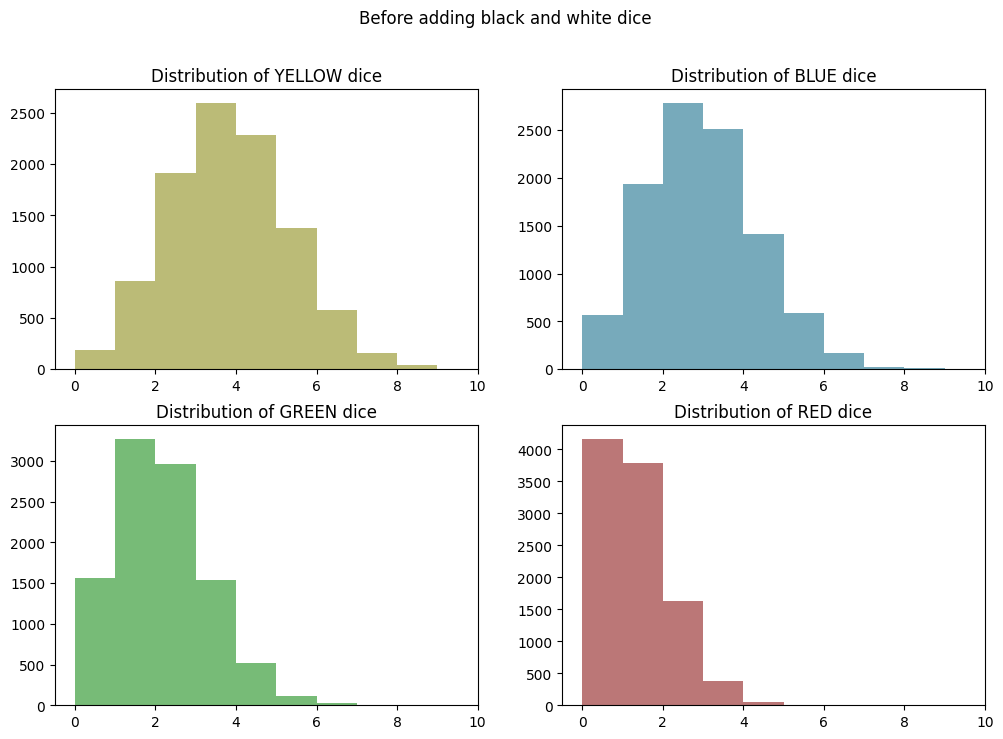

In [65]:
plt.clf()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, color in enumerate(["YELLOW", "BLUE", "GREEN", "RED"]):
    distribution = df_random_choices.apply(lambda row: row.value_counts().get(color, 0), axis=1)
    axes[i].hist(distribution, bins=range(df_random_choices.shape[1] + 1), color=COLOR_LOOKUP[color])
    axes[i].set_title(f"Distribution of {color} dice")
    axes[i].set_xlim(right=df_random_choices.shape[1])  # Set max value on x-axis

plt.suptitle("Before adding black and white dice")
plt.show()

<Figure size 640x480 with 0 Axes>

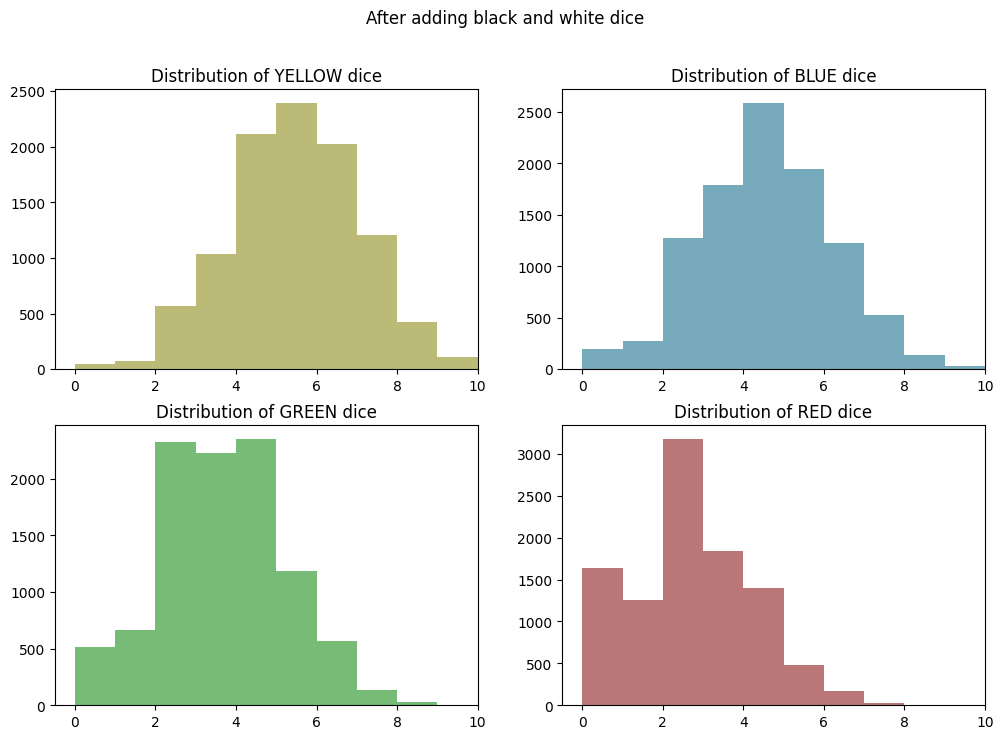

In [66]:
plt.clf()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, color in enumerate(["YELLOW", "BLUE", "GREEN", "RED"]):
    axes[i].hist(df_by_color[color], bins=range(df_random_choices.shape[1] + 1), color=COLOR_LOOKUP[color])
    axes[i].set_title(f"Distribution of {color} dice")
    axes[i].set_xlim(right=df_random_choices.shape[1])  # Set max value on x-axis

plt.suptitle("After adding black and white dice")
plt.show()

### Wild Results Have a Decent Impact

So it looks like adding in wild results has shifted each distribution up by a little less than two hits. This is to be expected, because both BLACK and WHITE have a 1:12 chance of being rolled, and white is slightly discounted, because it may not always be allocatable.

The impact is most pronounced on green and red. This is because their odds have been improved by a lot: 2X in the case of green (from 2:12 -> ~4:12) and 3X in the case of red (from 1:12 -> ~3:12).

Again, this effectively shows the maximum number of hits you *might* be able to allocate to each indvidual color. In a real game BLACK and WHITE results won't shift all of the colors up by the same amount, because you can only apply a wild to one color at a time. But presumably you would allocate the wild to the color that would benefit the most from it, so this is a reasonable upper bound on the number of hits you might expect to allocate to each color.

## Part 2 - Modeling the Probabilities in "Pure Math"

I'm very familiar with simulation approaches at this point. Practical and imperative math like this also makes a lot of sense to me as a programmer.

Now I'd like to take a more mathematical appraoch to the problem, which is not as natural to me.

I was trying to derive the formula myself while in the shower. It's clear that it's not as simple as looking at the probability of rolling a single color. We need to look at combined probabilities across any number of rolls.

I started by thinking about a specific case: how would you compute the probability that you could roll ten times and end up with zero yellow results? I *know* I studied this back in high school math, but twenty years later it's not exactly top of mind.

I realized that the probability of having no yellow results is the same as rolling non-yellow ten times in a row. That would be something like $(8/12)^10$. Not math I can do in my head, but definitely a small number. Using a calculator, there's about a 1.7% chance of this happening. Makes sense.

Then I moved on to the probability of having one out of ten results be yellow, and here I realized that I needed to somehow combine the probability of success with the probability of failure. That's where I got stuck mentally.

### Computing the Binomial Distribution

So I turned to Google and ChatGPT who pointed me at the Binomial Probability formula, which I can use to compute a Binomial Distribution for a given number of dice rolls and a given probability of success.

The formula for Binomial Probability is:

$$P(X = k) = \binom{n}{k} \times p^k \times (1-p)^{n-k}$$

where:
- $n$ is the number of trials (number of die rolls)
- $k$ is the number of successful outcomes (rolling a particular color)
- $p$ is the probability of success on a single trial
- $\binom{n}{k}$ represents the binomial coefficient, which is the number of ways to choose $k$ successes out of $n$ trials

My recollection of this formula is vague. Looking at it closely, I see that my intuitions were correct. The formula is basically using multiplication to combine the probability of getting $k$ successes with the probability of getting $n-k$ failures.

The big piece I was missing and failed to derive for myself was the binomial coefficient.

### The Binomial Coefficient

The binomial coefficient is the piece I was missing working through this problem in my head. This is how we can combine the probability $p^k$ of getting $k$ successes with the probability $(1-p)^{n-k}$ of getting $n-k$ failures.

The formula for the binomial coefficient is given by:

$$\binom{n}{k} = \frac{n!}{k! \cdot (n-k)!}$$

where:
- $n!$ denotes the factorial of $n$
- $k!$ denotes the factorial of $k$
- $(n-k)!$ denotes the factorial of $n-k$

#### Binomial Coefficient in Python

In Python we could implement a function that computes the binomial coefficient exactly as represented above using `math.factorial`. Python makes it even easier by providing this function in the standard library as `math.comb`.

Remembering that in our case $n$ is the number of dice rolls and $k$ is the number of rolls of a particular color. We can hold $n$ steady at 10 and see how the coefficient varies with $k$. So let's use `NUM_DICE` as $n$ from our simulations above. Then we'll step through every possible value of $k$ successful roles. That's the set of ${0, 1, 2 ... 10}$.

In [67]:
import math

n = NUM_DICE
for k in range(n + 1):
    print(k, math.comb(n, k))

0 1
1 10
2 45
3 120
4 210
5 252
6 210
7 120
8 45
9 10
10 1


So here we can see the rise and fall of the distribution in number form. It is centered around 5, because at this point we have not introduced any probabilities.

We can see that it in the binomial probability formula, this binomial coefficient functions to increase the "weight" of the success case against the failure case. At the center of the distribution it is a heavy weight, indeed. It multiplies the probability of the success case by up to 252 times!

Now let's put it all together in Python and make some more plots...

First, we'll define a function for binomial probability, based on the formula above and using `math.comb` again for the binomial coefficient.

In [68]:
def binomial_probability(n, k, p):
    return math.comb(n, k) * pow(p, k) * pow(1 - p, n - k)

Now, let's set up $n$ and $p_yellow$ then compute the binomial distribution for yellow.

In [69]:
n = NUM_DICE
p_yellow = 4 / 12

yellow_binom_dist = list((k, binomial_probability(n, k, p_yellow)) for k in range(n + 1))
yellow_binom_dist

[(0, 0.017341529915832633),
 (1, 0.08670764957916315),
 (2, 0.19509221155311707),
 (3, 0.26012294873748937),
 (4, 0.22760758014530316),
 (5, 0.13656454808718185),
 (6, 0.05690189503632578),
 (7, 0.016257684296093075),
 (8, 0.0030483158055174507),
 (9, 0.0003387017561686056),
 (10, 1.693508780843028e-05)]

Again, we see the rise and fall of the distribution in number form and that the peak is slightly shifted towards zero and centered on 3-4 successes, as we saw in the earlier simulation and would expect from the underlying probabilities.

We also see that the probabilities sum to 1.0 (allowing for some floating point error):

In [70]:
sum(prob for k, prob in yellow_binom_dist)

1.0000000000000007

Now let's plot this distribution side-by-side with the simulation results from earlier:

<Figure size 640x480 with 0 Axes>

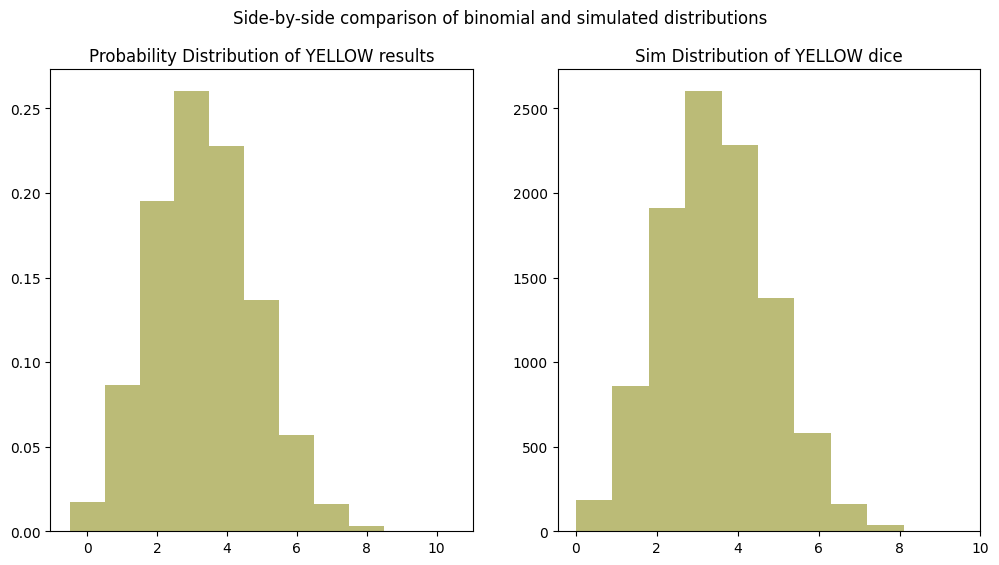

In [79]:
plt.clf()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()

x_values, y_values = zip(*yellow_binom_dist)
axes[0].set_title("Probability Distribution of YELLOW results")
axes[0].bar(x_values, y_values, align='center', color=COLOR_LOOKUP["YELLOW"], width=1)

axes[1].set_title(f"Sim Distribution of YELLOW dice")
axes[1].hist(yellow_distribution, bins=10, color=COLOR_LOOKUP["YELLOW"])
axes[1].set_xlim(right=10)

plt.suptitle("Side-by-side comparison of binomial and simulated distributions")
plt.show()

As expected, the distributions look identical!

### Wild Results - How to Sum Binomial Distributions